In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# Random
np.random.seed(42)

# Load data
file_path = ''
data = pd.read_csv(file_path)

# derive 'label' from the 'filename' column
data['label'] = data['filename'].apply(lambda x: 0 if 'benign' in x else 1)
# filter data for magnification(mag) == 40
data = data[data['mag'] == 40]

#prepare dataset
#parameters
target_size = (224, 224) #target size for Random Forest input
# Define the base path for images - data is in archive/BreaKHis_v1 folder (nested structure)
base_image_path = ''

# Function to preprocess images with proper path handling
def preprocess_images(dataframe, target_size, base_path):
    images = []
    labels = []
    for idx in tqdm(range(len(dataframe)), desc="Preprocessing images"):
        row = dataframe.iloc[idx]
        relative_img_path = row['filename']
        # Construct the full image path and normalize path separators
        img_path = os.path.join(base_path, relative_img_path)
        img_path = os.path.normpath(img_path)  # Convert forward slashes to backslashes on Windows
        label = row['label']

        #load image
        img = cv2.imread(img_path)
        if img is None:
            # Try to find the image with a debug print
            print(f"Debug: Looking for image at: {img_path}")
            print(f"Debug: File exists: {os.path.exists(img_path)}")
            if os.path.exists(os.path.dirname(img_path)):
                print(f"Debug: Directory exists, files in directory: {os.listdir(os.path.dirname(img_path))[:5]}")
            raise FileNotFoundError(f"Image not found: {img_path}")

        #Resize and preprocess
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB
        img = img / 255.0 # Normalize to [0, 1]
        images.append(img.flatten())  # Flatten the image for Random Forest
        labels.append(label)

    return np.array(images), np.array(labels)

# Split data into train and test based on 'grp'
train_df = data[data['grp'] == 'train']
test_df = data[data['grp'] == 'test']

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Class distribution - Benign: {sum(data['label'] == 0)}, Malignant: {sum(data['label'] == 1)}")

# Preprocess data
X_train, y_train = preprocess_images(train_df, target_size, base_image_path)
X_test, y_test = preprocess_images(test_df, target_size, base_image_path)

# Initialize Random Forest model
print("Initializing Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

# Train the model
print("Training Random Forest model...")
rf_model.fit(X_train, y_train)

# Test the model
print("Evaluating Random Forest model...")
y_pred = rf_model.predict(X_test)

# Print classification report
target_names = ['Benign', 'Malignant'] # define label name (fixed typo)
print(classification_report(y_test, y_pred, target_names=target_names))

Training samples: 6466
Test samples: 3509
Class distribution - Benign: 3125, Malignant: 6850


Preprocessing images: 100%|██████████| 3509/3509 [00:26<00:00, 132.63it/s]



Initializing Random Forest model...
Training Random Forest model...
Evaluating Random Forest model...
Evaluating Random Forest model...
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1160
   Malignant       1.00      1.00      1.00      2349

    accuracy                           1.00      3509
   macro avg       1.00      1.00      1.00      3509
weighted avg       1.00      1.00      1.00      3509

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1160
   Malignant       1.00      1.00      1.00      2349

    accuracy                           1.00      3509
   macro avg       1.00      1.00      1.00      3509
weighted avg       1.00      1.00      1.00      3509



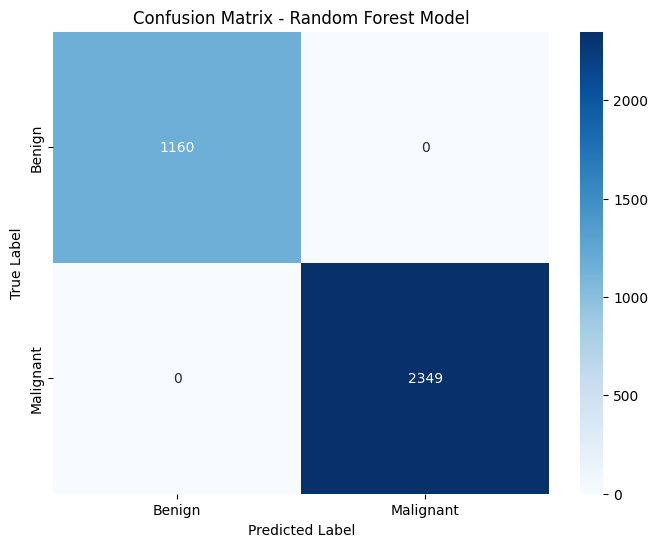

=== 隨機森林模型詳細效能指標 ===
整體準確率: 1.0000 (100.00%)

良性腫瘤:
精確率: 1.0000 (100.00%)
召回率: 1.0000 (100.00%)
F1-score: 1.0000

惡性腫瘤:
精確率: 1.0000 (100.00%)
召回率: 1.0000 (100.00%)
F1-score: 1.0000

=== 醫療意義分析 ===
假陰性(漏診惡性): 0 例 (0.00%)
假陽性(誤診良性為惡性): 0 例 (0.00%)
真陽性(正確診斷惡性): 2349 例
真陰性(正確診斷良性): 1160 例

=== 特徵重要性分析 ===
最重要的前10個像素位置:
1. 位置(34, 213) R通道: 0.001531
2. 位置(185, 72) G通道: 0.001242
3. 位置(166, 45) G通道: 0.001186
4. 位置(215, 77) G通道: 0.001057
5. 位置(190, 26) G通道: 0.001030
6. 位置(129, 18) R通道: 0.000992
7. 位置(38, 132) R通道: 0.000911
8. 位置(197, 22) G通道: 0.000894
9. 位置(167, 65) G通道: 0.000889
10. 位置(164, 95) G通道: 0.000864


In [2]:
# Additional analysis and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Random Forest Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision_benign = precision_score(y_test, y_pred, pos_label=0)
precision_malignant = precision_score(y_test, y_pred, pos_label=1)
recall_benign = recall_score(y_test, y_pred, pos_label=0)
recall_malignant = recall_score(y_test, y_pred, pos_label=1)
f1_benign = f1_score(y_test, y_pred, pos_label=0)
f1_malignant = f1_score(y_test, y_pred, pos_label=1)

print("=== 隨機森林模型詳細效能指標 ===")
print(f"整體準確率: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\n良性腫瘤:")
print(f"精確率: {precision_benign:.4f} ({precision_benign*100:.2f}%)")
print(f"召回率: {recall_benign:.4f} ({recall_benign*100:.2f}%)")
print(f"F1-score: {f1_benign:.4f}")
print(f"\n惡性腫瘤:")
print(f"精確率: {precision_malignant:.4f} ({precision_malignant*100:.2f}%)")
print(f"召回率: {recall_malignant:.4f} ({recall_malignant*100:.2f}%)")
print(f"F1-score: {f1_malignant:.4f}")

# Medical significance
print(f"\n=== 醫療意義分析 ===")
print(f"假陰性(漏診惡性): {cm[1,0]} 例 ({cm[1,0]/np.sum(cm[1,:])*100:.2f}%)")
print(f"假陽性(誤診良性為惡性): {cm[0,1]} 例 ({cm[0,1]/np.sum(cm[0,:])*100:.2f}%)")
print(f"真陽性(正確診斷惡性): {cm[1,1]} 例")
print(f"真陰性(正確診斷良性): {cm[0,0]} 例")

# Feature importance analysis for Random Forest
feature_importance = rf_model.feature_importances_
print(f"\n=== 特徵重要性分析 ===")
print(f"最重要的前10個像素位置:")
top_features = np.argsort(feature_importance)[-10:][::-1]
for i, feature_idx in enumerate(top_features):
    pixel_row = feature_idx // (target_size[1] * 3)
    pixel_col = (feature_idx % (target_size[1] * 3)) // 3
    color_channel = feature_idx % 3
    channel_names = ['R', 'G', 'B']
    print(f"{i+1}. 位置({pixel_row}, {pixel_col}) {channel_names[color_channel]}通道: {feature_importance[feature_idx]:.6f}")